In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss
from statsmodels.stats.multitest import multipletests
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

# Unperturbed yeast gene expression level features: SHAP vs feature value

In [2]:
cc_perm_df = pd.read_csv('tables/SupplementalTable_CallingCards.csv')
cc_tfs = cc_perm_df.loc[cc_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

chipexo_perm_df = pd.read_csv('tables/SupplementalTable_ChIP-exo.csv')
chipexo_tfs = chipexo_perm_df.loc[chipexo_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

gex_shap_df = pd.DataFrame()

gex_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', cc_tfs,
    '../OUTPUT/yeast_cc/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    is_tf_dependent=True
)
gex_shap_subdf['assay_type'] = 'Calling Cards'
gex_shap_df = gex_shap_df.append(gex_shap_subdf, ignore_index=True)

gex_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', chipexo_tfs,
    '../OUTPUT/yeast_chipexo/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    is_tf_dependent=True
)
gex_shap_subdf['assay_type'] = 'ChIP-exo'
gex_shap_df = gex_shap_df.append(gex_shap_subdf, ignore_index=True)

Loading feature data ... 0 1 
Loading feature data ... 0 1 


[ 1.45876057  2.65614396  0.2936866  -1.27397644]


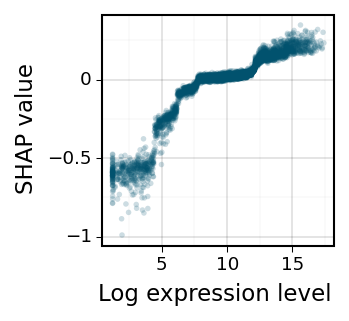

<ggplot: (-9223370607360964597)>

In [3]:
tf_of_interest = 'YNL199C' # GCR2

plot_df = gex_shap_df[
    (gex_shap_df['tf'] == tf_of_interest) & \
    (gex_shap_df['assay_type'] == 'Calling Cards')
]

opt_params, _ = curve_fit(sigmoid, plot_df['input'], plot_df['shap'], method='trf')
print(opt_params)
sig_x = np.linspace(min(plot_df['input']), max(plot_df['input']))
sig_y = sigmoid(sig_x, *opt_params)
curve = pd.DataFrame({'input': sig_x, 'fit_shap': sig_y})

ax = (
    ggplot()
    + geom_point(
        plot_df, 
        aes(x='input', y='shap'), alpha=.2, stroke=0, color=COLORS['dark_blue'])
#     + geom_line(curve, aes(x='input', y='fit_shap'), color=COLORS['red'], size=1)
    + xlab('Log expression level')
    + ylab('SHAP value')
    + theme_linedraw()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GCR2_GEX_vs_SHAP.pdf')

# Unperturbed yeast gene expression variation features: SHAP vs feature value

In [4]:
gex_var_shap_df = pd.DataFrame()

gex_var_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', cc_tfs,
    '../OUTPUT/yeast_cc/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    feat_name='variation'
)
gex_var_shap_subdf['assay_type'] = 'Calling Cards'
gex_var_shap_df = gex_var_shap_df.append(gex_var_shap_subdf, ignore_index=True)

gex_var_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', chipexo_tfs,
    '../OUTPUT/yeast_chipexo/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    feat_name='variation'
)
gex_var_shap_subdf['assay_type'] = 'ChIP-exo'
gex_var_shap_df = gex_var_shap_df.append(gex_var_shap_subdf, ignore_index=True)

Loading feature data ... 0 1 
Loading feature data ... 0 1 


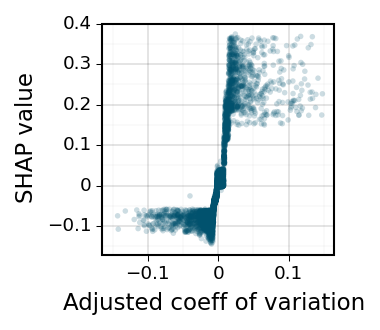

<ggplot: (1429486841811)>

In [8]:
plot_df = gex_var_shap_df[
    (gex_var_shap_df['tf'] == 'YNL199C') & \
    (gex_var_shap_df['assay_type'] == 'ChIP-exo')
]

# opt_params, _ = curve_fit(sigmoid, plot_df['input'], plot_df['shap'], method='trf')
# print(opt_params)
# sig_x = np.linspace(min(plot_df['input']), max(plot_df['input']))
# sig_y = sigmoid(sig_x, *opt_params)
# curve = pd.DataFrame({'input': sig_x, 'fit_shap': sig_y})

ax = (
    ggplot()
    + geom_point(
        plot_df, 
        aes(x='input', y='shap'), alpha=.2, stroke=0, color=COLORS['dark_blue'])
#     + geom_line(curve, aes(x='input', y='fit_shap'), color=COLORS['red'], size=1)
    + xlab('Adjusted coeff of variation')
    + ylab('SHAP value')
    + xlim(-.15, .15)
    + theme_linedraw()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GCR2_GEX_variation_vs_SHAP.pdf')

# Correlate yeast GEX feature value with SHAP influence

In [5]:
corr_df = pd.DataFrame()

for (assay_type, tf), gex_shap_subdf in gex_shap_df.groupby(['assay_type', 'tf']):
    rho, p = ss.pearsonr(gex_shap_subdf['input'], gex_shap_subdf['shap'])
    corr_se = pd.Series({
        'rho': rho, 'p': p,
        'assay_type': assay_type, 'tf': tf,
        'gex_type': 'Expression Level'
    })
    corr_df = corr_df.append(corr_se, ignore_index=True)
    
for (assay_type, tf), gex_var_shap_subdf in gex_var_shap_df.groupby(['assay_type', 'tf']):
    rho, p = ss.pearsonr(gex_var_shap_subdf['input'], gex_var_shap_subdf['shap'])
    corr_se = pd.Series({
        'rho': rho, 'p': p,
        'assay_type': assay_type, 'tf': tf,
        'gex_type': 'Expression Variation'
    })
    corr_df = corr_df.append(corr_se, ignore_index=True)

In [6]:
corr_df

,assay_type,gex_type,p,rho,tf
0,Calling Cards,Expression Level,0.0,0.916757,YDR034C
1,Calling Cards,Expression Level,0.0,0.938067,YEL009C
2,Calling Cards,Expression Level,0.0,0.948781,YIL036W
3,Calling Cards,Expression Level,0.0,0.910583,YJL056C
4,Calling Cards,Expression Level,0.0,0.895324,YJR060W
5,Calling Cards,Expression Level,0.0,0.905653,YKL038W
6,Calling Cards,Expression Level,0.0,0.914546,YLR403W
7,Calling Cards,Expression Level,0.0,0.900618,YLR451W
8,Calling Cards,Expression Level,0.0,0.911361,YMR182C
9,Calling Cards,Expression Level,0.0,0.908984,YNL199C


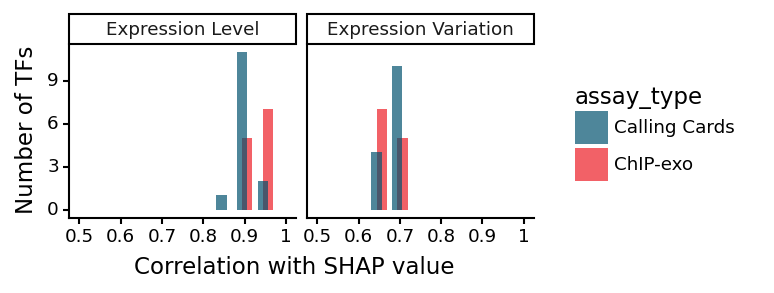

<ggplot: (2958997563663)>

In [9]:
ax = (
    ggplot(corr_df, aes(x='rho', fill='assay_type'))
    + geom_histogram(binwidth=.05, position=position_dodge(.025), alpha=.7)
    + scale_fill_manual([COLORS['dark_blue'], COLORS['red']])
    + scale_x_continuous(lim=(-1, 1), breaks=np.arange(-1, 1.1, .1))
    + xlim([.5, 1])
    + labs(x='Correlation with SHAP value', y='Number of TFs')
    + facet_wrap('gex_type')
    + theme_classic()
    + theme(
        figure_size=(4, 1.5), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GEX_vs_shap_histogram.pdf')

# Unperturbed human gene expression level features: SHAP vs feature value

In [2]:
# Get K562 TFs with significant model
k562_perm_df = pd.read_csv('tables/SupplementalTable_K562.csv')
k562_tfs = k562_perm_df.loc[k562_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

# All H1 TF models are significant
h1_perm_df = pd.read_csv('tables/SupplementalTable_H1_TGI.csv')
h1_tfs = h1_perm_df.loc[h1_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

# All HEK293 TF models are significant
hek293_perm_df = pd.read_csv('tables/SupplementalTable_HEK293.csv')
hek293_tfs = hek293_perm_df.loc[hek293_perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

In [3]:
gex_shap_df = pd.DataFrame()

gex_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', k562_tfs,
    '../OUTPUT/human_k562/all_feats/',
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    is_resp_format_long=True,
    feat_name='median_level',
    
)
gex_shap_subdf['cell_line'] = 'K562'
gex_shap_df = gex_shap_df.append(gex_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_shap_subdf

gex_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', h1_tfs,
    '../OUTPUT/human_h1/all_feats/',
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    is_resp_format_long=True,
    feat_name='median_level',
    
)
gex_shap_subdf['cell_line'] = 'H1'
gex_shap_df = gex_shap_df.append(gex_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_shap_subdf

gex_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', hek293_tfs,
    '../OUTPUT/human_hek293/all_feats/',
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    is_resp_format_long=True,
    feat_name='median_level',
    
)
gex_shap_subdf['cell_line'] = 'HEK293'
gex_shap_df = gex_shap_df.append(gex_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_shap_subdf

Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 


In [4]:
gex_var_shap_df = pd.DataFrame()

gex_var_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', k562_tfs,
    '../OUTPUT/human_k562/all_feats/',
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    is_resp_format_long=True,
    feat_name='variation',
    
)
gex_var_shap_subdf['cell_line'] = 'K562'
gex_var_shap_df = gex_var_shap_df.append(gex_var_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_var_shap_subdf

gex_var_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', h1_tfs,
    '../OUTPUT/human_h1/all_feats/',
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    is_resp_format_long=True,
    feat_name='variation',
    
)
gex_var_shap_subdf['cell_line'] = 'H1'
gex_var_shap_df = gex_var_shap_df.append(gex_var_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_var_shap_subdf

gex_var_shap_subdf = link_shap_to_coord_feats(
    'gene_expression', hek293_tfs,
    '../OUTPUT/human_hek293/all_feats/',
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    is_resp_format_long=True,
    feat_name='variation',
    
)
gex_var_shap_subdf['cell_line'] = 'HEK293'
gex_var_shap_df = gex_var_shap_df.append(gex_var_shap_subdf[['cell_line', 'tf', 'feat_idx', 'shap', 'input']], ignore_index=True)
del gex_var_shap_subdf

Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 


In [10]:
gex_shap_df.to_csv('helper_data/human_gex_shap_df.csv.gz', index=False)
gex_var_shap_df.to_csv('helper_data/human_gex_var_shap_df.csv.gz', index=False)

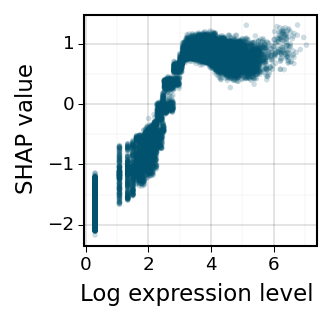

<ggplot: (-9223370607362768142)>

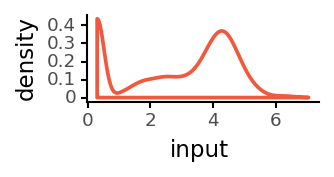

<ggplot: (1429455715988)>

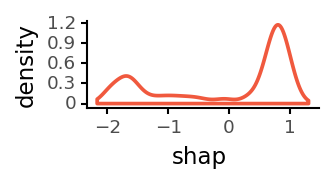

<ggplot: (1429485793975)>

In [11]:
tf_of_interest = 'ENSG00000130522'  # JUND
plot_df = gex_shap_df[(gex_shap_df['tf'] == tf_of_interest) & (gex_shap_df['cell_line'] == 'K562')]

ax = (
    ggplot()
    + geom_point(
        plot_df, 
        aes(x='input', y='shap'), alpha=.2, stroke=0, color=COLORS['dark_blue'])
    + xlab('Log expression level')
    + ylab('SHAP value')
    + theme_linedraw()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_med_vs_SHAP.pdf')

ax = (
    ggplot(plot_df, aes(x='input'))
    + geom_density(size=1, color=COLORS['orange'])
    + theme_classic()
    + theme(figure_size=(2, .75), dpi=150)
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_med_input_dist.pdf')

ax = (
    ggplot(plot_df, aes(x='shap'))
    + geom_density(size=1, color=COLORS['orange'])
    + theme_classic()
    + theme(figure_size=(2, .75), dpi=150)
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_med_SHAP_dist.pdf')

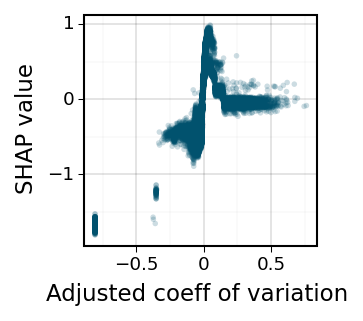

<ggplot: (1429486869894)>

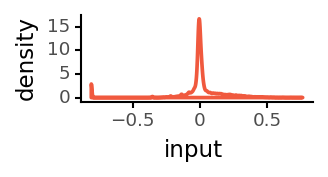

<ggplot: (1429481287053)>

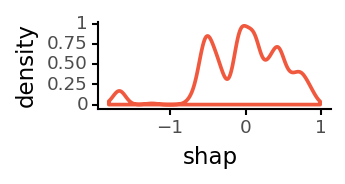

<ggplot: (-9223370607396174094)>

In [12]:
tf_of_interest = 'ENSG00000130522'  # JUND
plot_df = gex_var_shap_df[(gex_var_shap_df['tf'] == tf_of_interest) & (gex_var_shap_df['cell_line'] == 'K562')]

ax = (
    ggplot()
    + geom_point(
        plot_df, 
        aes(x='input', y='shap'), alpha=.2, stroke=0, color=COLORS['dark_blue'])
    + xlab('Adjusted coeff of variation')
    + ylab('SHAP value')
    + theme_linedraw()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_var_vs_SHAP.pdf')

ax = (
    ggplot(plot_df, aes(x='input'))
    + geom_density(size=1, color=COLORS['orange'])
    + theme_classic()
    + theme(figure_size=(2, .75), dpi=150)
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_var_input_dist.pdf')

ax = (
    ggplot(plot_df, aes(x='shap'))
    + geom_density(size=1, color=COLORS['orange'])
    + theme_classic()
    + theme(figure_size=(2, .75), dpi=150)
)
display(ax)
ax.save('figures/Human_K562_JUN_GEX_var_SHAP_dist.pdf')

# Correlate yeast GEX feature value with SHAP influence

In [13]:
corr_df = pd.DataFrame()

for (cell_line, tf), gex_shap_subdf in gex_shap_df[~gex_shap_df['input'].isnull()].groupby(['cell_line', 'tf']):
    rho, p = ss.pearsonr(gex_shap_subdf['input'], gex_shap_subdf['shap'])
    corr_se = pd.Series({
        'rho': rho, 'p': p,
        'cell_line': cell_line, 'tf': tf,
        'gex_type': 'Expression Level'
    })
    corr_df = corr_df.append(corr_se, ignore_index=True)
    
for (cell_line, tf), gex_var_shap_subdf in gex_var_shap_df[~gex_var_shap_df['input'].isnull()].groupby(['cell_line', 'tf']):
    rho, p = ss.pearsonr(gex_var_shap_subdf['input'], gex_var_shap_subdf['shap'])
    corr_se = pd.Series({
        'rho': rho, 'p': p,
        'cell_line': cell_line, 'tf': tf,
        'gex_type': 'Expression Variation'
    })
    corr_df = corr_df.append(corr_se, ignore_index=True)

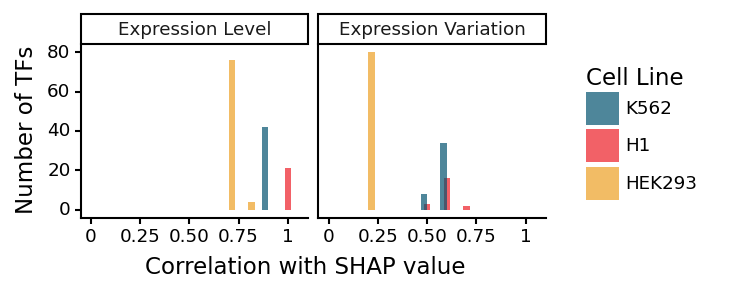

<ggplot: (-9223370594323613226)>

In [14]:
corr_df['cell_line'] = pd.Categorical(corr_df['cell_line'], ordered=True, categories=['K562', 'H1', 'HEK293'])

ax = (
    ggplot(corr_df, aes(x='rho', fill='cell_line'))
    + geom_histogram(binwidth=.1, position=position_dodge(.05), alpha=.7)
    + scale_fill_manual([COLORS['dark_blue'], COLORS['red'], COLORS['yellow']])
    + xlim([0, 1.05])
    + labs(x='Correlation with SHAP value', y='Number of TFs', fill='Cell Line')
    + facet_wrap('gex_type')
    + theme_classic()
    + theme(
        figure_size=(4, 1.5), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_GEX_vs_shap_histogram.pdf')